<a href="https://colab.research.google.com/github/FlorianHuber-Math/X-Ray-classification-Keggle-Pneumonia-Dataset-/blob/master/X_ray_calssification_(transfer_learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, math, json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
tf.enable_eager_execution()
AUTO = tf.data.experimental.AUTOTUNE
from google.colab import files
from glob import glob #retriving an array of files in directories
import seaborn as sns
from random import shuffle
import random
from tqdm import tqdm  
import cv2 
import skimage
from skimage.transform import resize
from pathlib import Path


# for alternative image augentation
from keras.preprocessing.image import ImageDataGenerator #Data augmentation and preprocessing
from keras.utils import to_categorical #For One-hot Encoding


from sklearn.metrics import classification_report, confusion_matrix

import imgaug.augmenters as iaa

Tensorflow version 1.14.0


Using TensorFlow backend.


# Importing the dataset from Kaggle


In [2]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle!mkdir -p ~/.kaggle

     |████████████████████████████████| 61kB 3.9MB/s 


In [0]:
from google.colab import files
files.upload()

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets list -s x-ray

In [0]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!unzip \chest-xray-pneumonia.zip

In [0]:
!unzip \chest_xray.zip ;

In [0]:
path_train = '/content/chest_xray/train/'
path_val = '/content/chest_xray/val/'
path_test = '/content/chest_xray/test/'


In [0]:
img = glob(path_train+'PNEUMONIA/*.jpeg') #Getting all images in this folder

In [12]:
len(img)

3875

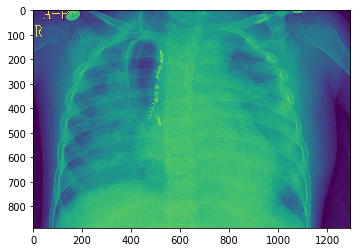

In [13]:
img = np.asarray(plt.imread(img[0]))
plt.imshow(img)

In [14]:
img.shape

(888, 1296)

## Setting some parameters

In [0]:
image_height = 150
image_width = 150

batch_size_training_generator = 16
batch_size_test_generator = 16
batch_size_validation_generator = 16

BATCH_SIZE = 64 # 128 works on GPU too but comes very close to the memory limit of the Colab GPU
EPOCHS = 10
IMAGE_SIZE = [image_height, image_width]
#validation_steps = (len(images_val_normal)+len(images_val_pneumonia)) // BATCH_SIZE
validation_steps = (len(images_test_normal)+len(images_test_pneumonia)) // BATCH_SIZE
#validation_steps = 10
steps_per_epoch = (len(images_train_normal)+len(images_train_pneumonia))//BATCH_SIZE


In [0]:
validation_steps

9

# Plotting the X-Rays of No Pneumonia and Pneumonia patients

In [0]:
images_train_pneumonia = os.listdir(path_train + 'PNEUMONIA')
images_train_normal = os.listdir(path_train + 'NORMAL')

images_test_pneumonia = os.listdir(path_test + 'PNEUMONIA')
images_test_normal = os.listdir(path_test + 'NORMAL')

images_val_pneumonia = os.listdir(path_val + 'PNEUMONIA')
images_val_normal = os.listdir(path_val + 'NORMAL')



path_string_train_normal = path_train + 'NORMAL'
path_string_train_pneumonia = path_train + 'PNEUMONIA'

path_string_test_normal = path_test + 'NORMAL'
path_string_test_pneumonia = path_test + 'PNEUMONIA'

path_string_val_normal = path_val + 'NORMAL'
path_string_val_pneumonia = path_val + 'PNEUMONIA'

# Get the list of all the images
normal_cases_train = Path(path_string_train_normal).glob('*.jpeg')
pneumonia_cases_train = Path(path_string_train_pneumonia).glob('*.jpeg')

normal_cases_test = Path(path_string_test_normal).glob('*.jpeg')
pneumonia_cases_test = Path(path_string_test_pneumonia).glob('*.jpeg')

normal_cases_val = Path(path_string_val_normal).glob('*.jpeg')
pneumonia_cases_val = Path(path_string_val_pneumonia).glob('*.jpeg')

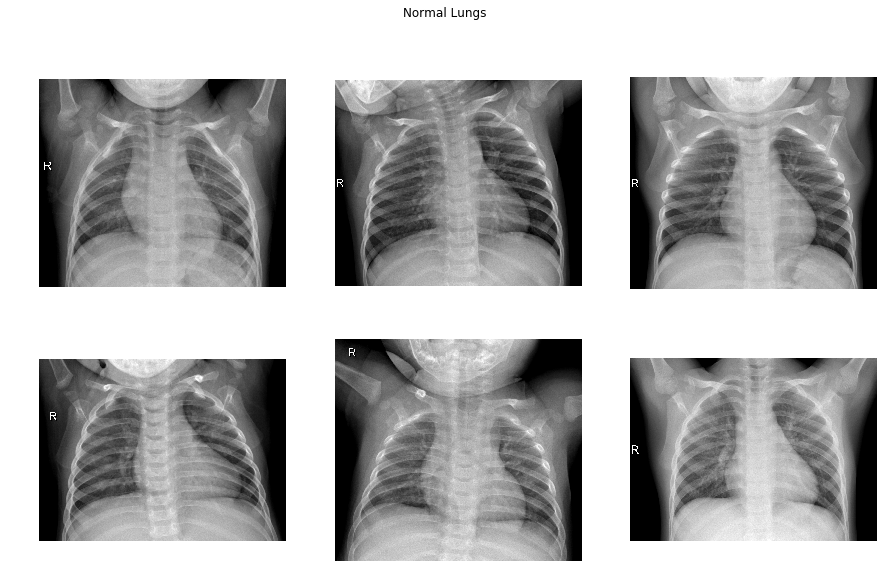

In [50]:
sample_normal = random.sample(images_train_normal,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread(path_train +'NORMAL/'+sample_normal[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Normal Lungs')
plt.show()

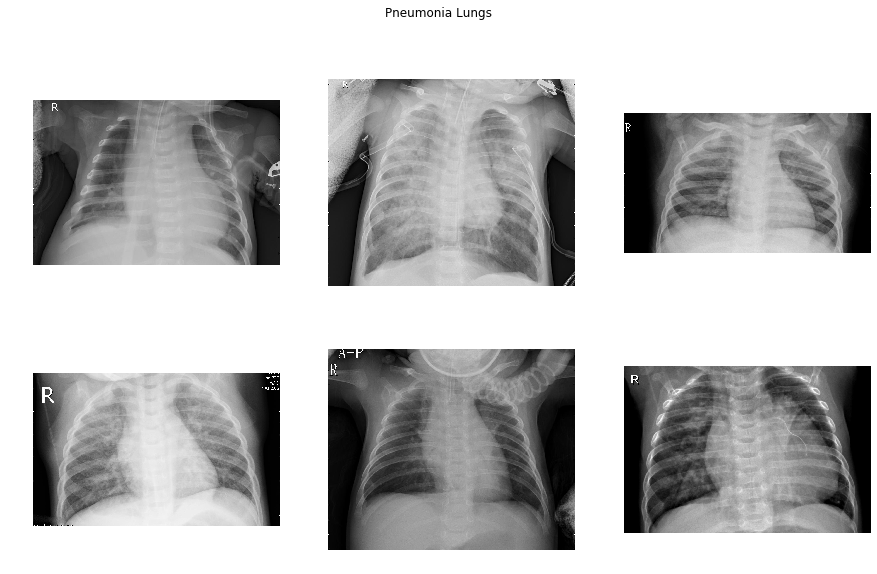

In [51]:
sample_pneumonia = random.sample(images_train_pneumonia,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread(path_train +'PNEUMONIA/'+sample_pneumonia[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Pneumonia Lungs')
plt.show()

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


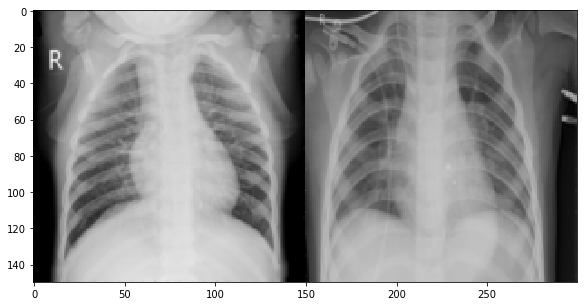

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


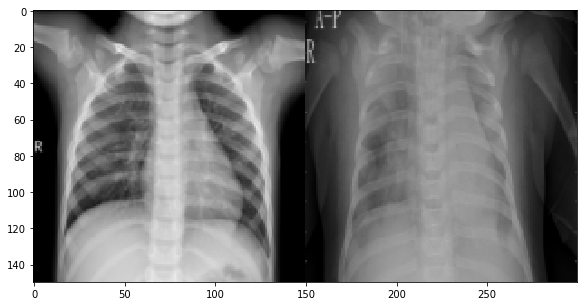

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


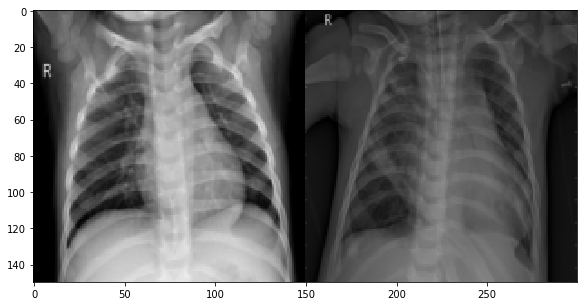

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


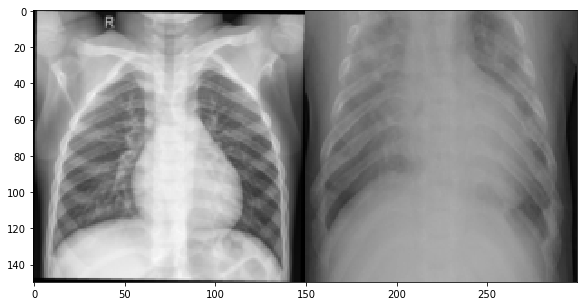

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


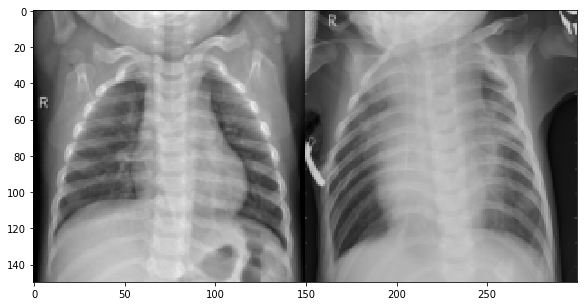

In [52]:
import matplotlib.pyplot as plt
def plotter(i,image_height,image_width):
    imagep1 = cv2.imread(path_train+'PNEUMONIA/'+images_train_pneumonia[i])
    imagep1 = skimage.transform.resize(imagep1, (image_height, image_width, 3) , mode = 'reflect')
    imagen1 = cv2.imread(path_train+'NORMAL/'+images_train_normal[i])
    imagen1 = skimage.transform.resize(imagen1, (image_height, image_width, 3))
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print("(Left) - No Pneumonia Vs (Right) - Pneumonia")
    print("-----------------------------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(5,10):
    plotter(i,image_height,image_width)

# Data (pre)processing

## Data processing

In [0]:
classes = ['NORMAL', 'PNEUMONIA']

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)  #Image normalization.

In [61]:
training_set = train_datagen.flow_from_directory('/content/chest_xray/train',
                                                 target_size = (image_height, image_width),
                                                 batch_size = batch_size_training_generator,
                                                 classes = classes,
                                                 class_mode = 'categorical')

validation_set = test_datagen.flow_from_directory('/content/chest_xray/val/',
                                                        target_size=(image_height, image_width),
                                                        batch_size=batch_size_test_generator,
                                                        classes = classes,
                                                        class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/chest_xray/test',
                                            target_size = (image_height, image_width),
                                            batch_size = batch_size_validation_generator,
                                            classes = classes,
                                            class_mode = 'categorical')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [62]:
training_set.image_shape

(150, 150, 3)

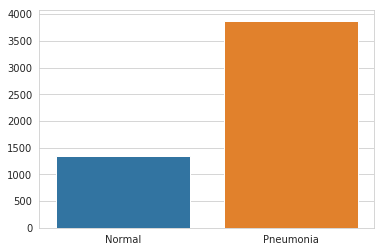

In [63]:
total_images_train_pneumonia = os.listdir(path_train+'PNEUMONIA/')
total_images_train_normal = os.listdir(path_train+'NORMAL/')
total_train_images = total_images_train_pneumonia + total_images_train_normal
sns.set_style('whitegrid')
sns.barplot(x=['Normal','Pneumonia'],y=[len(total_images_train_normal),len(total_images_train_pneumonia)])

In [57]:
IMAGE_SIZE

[150, 150]

## Specifying and training the model

In [64]:
pretrained_model = tf.keras.applications.InceptionV3(input_shape=[*IMAGE_SIZE, 3], include_top=False)
#pretrained_model = tf.keras.applications.InceptionV3(input_shape=train_batches.image_shape, include_top=False)
#pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 36866     
Total params: 21,839,650
Trainable params: 36,866
Non-trainable params: 21,802,784
_________________________________________________________________


In [65]:
history = model.fit_generator(training_set,
                         steps_per_epoch = steps_per_epoch,
                         epochs = EPOCHS,
                         validation_data = test_set,
                         validation_steps = validation_steps)

Epoch 1/10
81/81 [==============================] - 103s 1s/step - loss: 1.1157 - acc: 0.7909 - val_loss: 5.5559 - val_acc: 0.6181
Epoch 2/10
81/81 [==============================] - 92s 1s/step - loss: 0.4494 - acc: 0.8812 - val_loss: 4.8284 - val_acc: 0.6181
Epoch 3/10
81/81 [==============================] - 92s 1s/step - loss: 0.4584 - acc: 0.8804 - val_loss: 4.9269 - val_acc: 0.6181
Epoch 4/10
81/81 [==============================] - 91s 1s/step - loss: 0.3963 - acc: 0.9028 - val_loss: 4.2021 - val_acc: 0.6389
Epoch 5/10
81/81 [==============================] - 95s 1s/step - loss: 0.4593 - acc: 0.8789 - val_loss: 2.8707 - val_acc: 0.6806
Epoch 6/10
81/81 [==============================] - 95s 1s/step - loss: 0.5263 - acc: 0.8943 - val_loss: 6.0940 - val_acc: 0.6111
Epoch 7/10
81/81 [==============================] - 95s 1s/step - loss: 0.5170 - acc: 0.9012 - val_loss: 2.5958 - val_acc: 0.6597
Epoch 8/10
81/81 [==============================] - 92s 1s/step - loss: 0.5387 - acc: 0.8

# Model accuracy, loss and confusion matrix

In [0]:
history_model = history

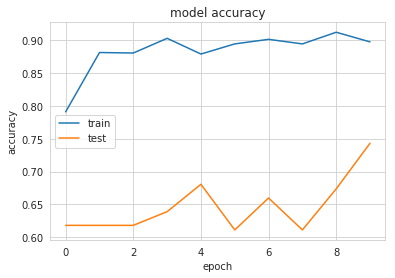

In [67]:
plt.plot(history_model.history['acc'])
plt.plot(history_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

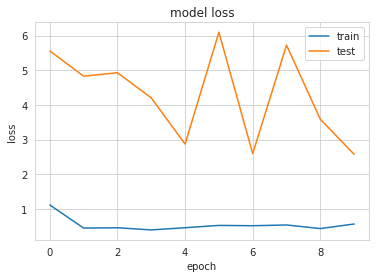

In [68]:
# summarize history for loss
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [69]:
Y_pred_train = model.predict_generator(training_set)
y_pred_train = np.argmax(Y_pred_train, axis=1)
print('Confusion Matrix')
print(confusion_matrix(training_set.classes, y_pred_train))
print('Classification Report')
target_names = ['Pneumonia', 'Normal']
print(classification_report(training_set.classes, y_pred_train, target_names=target_names))

Confusion Matrix
[[ 337 1004]
 [ 885 2990]]
Classification Report
              precision    recall  f1-score   support

   Pneumonia       0.28      0.25      0.26      1341
      Normal       0.75      0.77      0.76      3875

    accuracy                           0.64      5216
   macro avg       0.51      0.51      0.51      5216
weighted avg       0.63      0.64      0.63      5216



In [70]:
Y_pred_test = model.predict_generator(test_set)
y_pred_test = np.argmax(Y_pred_test, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred_test))
print('Classification Report')
target_names = ['Pneumonia', 'Normal']
print(classification_report(test_set.classes, y_pred_test, target_names=target_names))

Confusion Matrix
[[ 60 174]
 [ 89 301]]
Classification Report
              precision    recall  f1-score   support

   Pneumonia       0.40      0.26      0.31       234
      Normal       0.63      0.77      0.70       390

    accuracy                           0.58       624
   macro avg       0.52      0.51      0.50       624
weighted avg       0.55      0.58      0.55       624



In [71]:
Y_pred_val = model.predict_generator(validation_set)
y_pred_val = np.argmax(Y_pred_val, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_set.classes, y_pred_val))
print('Classification Report')
target_names = ['Pneumonia', 'Normal']
print(classification_report(validation_set.classes, y_pred_val, target_names=target_names))

Confusion Matrix
[[2 6]
 [3 5]]
Classification Report
              precision    recall  f1-score   support

   Pneumonia       0.40      0.25      0.31         8
      Normal       0.45      0.62      0.53         8

    accuracy                           0.44        16
   macro avg       0.43      0.44      0.42        16
weighted avg       0.43      0.44      0.42        16



Plot cases based on test set

In [0]:
y_values_predicted = y_pred_test
y_values_actual = test_set.classes
filenames = test_set.filenames

In [80]:
predictions = y_values_predicted
len(predictions)
len(y_values_actual)

624

Change binary labels to strings

In [0]:
actual_label = []

for i in range(len(y_values_actual )):
  if y_values_actual [i] == 0:
    actual_label.append('NORMAL')
  else:
      actual_label.append('PNEUMONIA') 

In [0]:
predicted_label = []

for i in range(len(y_values_predicted)):
  if y_values_predicted[i] == 0:
    predicted_label.append('NORMAL')
  else:
      predicted_label.append('PNEUMONIA') 

In [0]:
results=pd.DataFrame({'Filename':filenames,
                      'Predictions':predicted_label,
                      'Actual':actual_label})

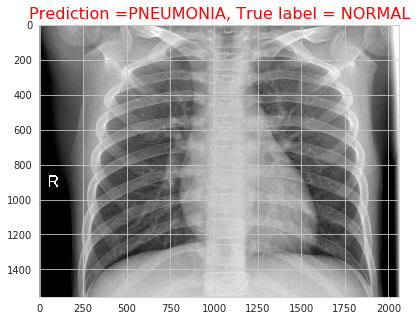

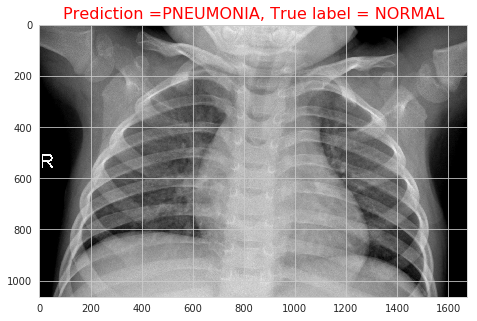

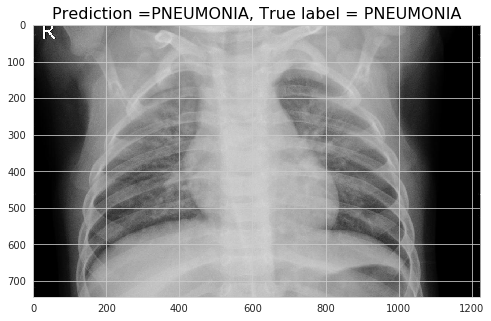

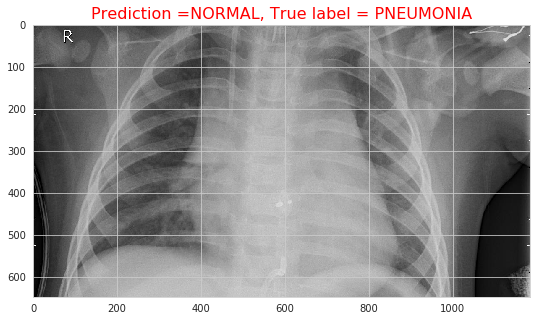

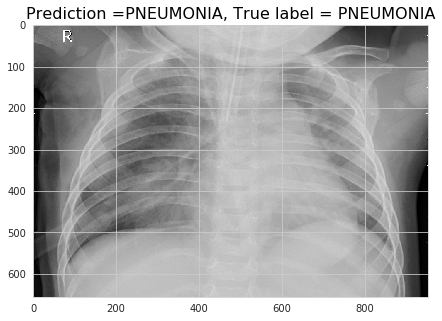

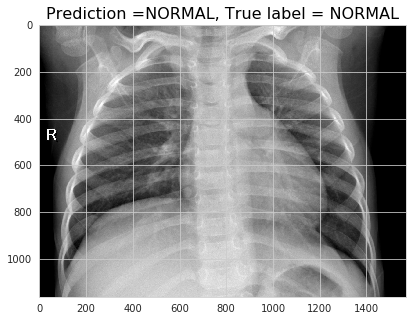

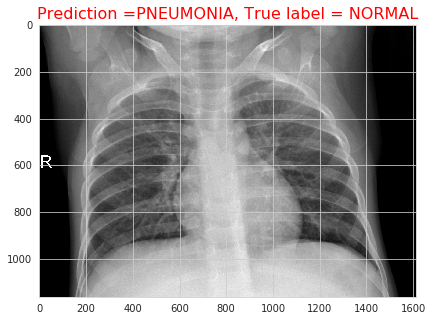

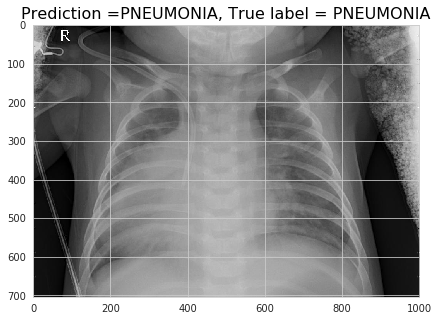

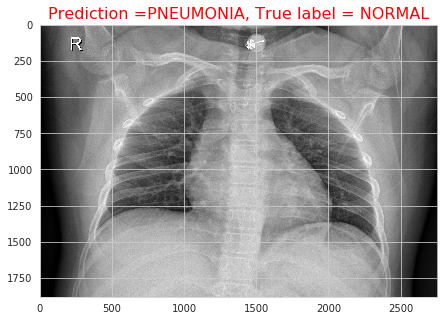

In [90]:
predictions = results['Predictions']
labels = results['Actual']

pictures = random.sample(range(0, len(predictions)), 9)

for i in pictures:
    true = predictions[i] == labels[i]
    imagepn = cv2.imread(path_test+filenames[i])
    plt.figure(figsize=(10,5))
    plt.title('Prediction ={}, True label = {}'.format(predictions[i],labels[i]), fontsize=16, color='red' if not true else 'black')
    plt.imshow(imagepn)

  

# Two other approaches to process the data

## Attempt 1 

### Data preprocessing

**This approach is more explicit but the model ran out of RAM in Google Colab **

In [0]:
def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                label = 0
            elif nextdir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
    return nextdir, label

In [0]:
def preprocessing_data(Dir):
    X = []
    y = []
    
    for nextdir in os.listdir(Dir):
        nextdir, label = get_label(Dir)
        temp = Dir + nextdir
        
        for image_filename in tqdm(os.listdir(temp)):
            path = os.path.join(temp + '/' , image_filename)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = skimage.transform.resize(img, (image_height, image_width, 3))
                img = np.asarray(img)
                X.append(img)
                y.append(label)
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [0]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (image_height, image_width, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(299, 299, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [0]:
X_train, y_train = get_data(path_train)

100%|██████████| 1342/1342 [10:48<00:00,  2.84it/s]


In [0]:
X_test , y_test = get_data(path_test)

100%|██████████| 234/234 [02:15<00:00,  1.43it/s]


In [0]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

### Specifying and training the model

In [0]:
#pretrained_model = tf.keras.applications.InceptionV3(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model = tf.keras.applications.InceptionV3(input_shape=train_batches.image_shape, include_top=False)
#pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_14 (Flatten)         (None, 18432)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 36866     
Total params: 21,839,650
Trainable params: 36,866
Non-trainable params: 21,802,784
_________________________________________________________________


Training the model

In [0]:
# history = model.fit(X_train, y_train, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, validation_data = (X_test , y_test), validation_steps=validation_steps)

## Attempt 2

### Data Preprocessing

In [0]:
images_train_pneumonia = os.listdir(path_train + 'PNEUMONIA')
images_train_normal = os.listdir(path_train + 'NORMAL')

images_test_pneumonia = os.listdir(path_test + 'PNEUMONIA')
images_test_normal = os.listdir(path_test + 'NORMAL')

images_val_pneumonia = os.listdir(path_val + 'PNEUMONIA')
images_val_normal = os.listdir(path_val + 'NORMAL')



path_string_train_normal = path_train + 'NORMAL'
path_string_train_pneumonia = path_train + 'PNEUMONIA'

path_string_test_normal = path_test + 'NORMAL'
path_string_test_pneumonia = path_test + 'PNEUMONIA'

path_string_val_normal = path_val + 'NORMAL'
path_string_val_pneumonia = path_val + 'PNEUMONIA'

# Get the list of all the images
normal_cases_train = Path(path_string_train_normal).glob('*.jpeg')
pneumonia_cases_train = Path(path_string_train_pneumonia).glob('*.jpeg')

normal_cases_test = Path(path_string_test_normal).glob('*.jpeg')
pneumonia_cases_test = Path(path_string_test_pneumonia).glob('*.jpeg')

normal_cases_val = Path(path_string_val_normal).glob('*.jpeg')
pneumonia_cases_val = Path(path_string_val_pneumonia).glob('*.jpeg')

Go through all training images and append a label

In [0]:
train_data = []

for img in normal_cases_train:
    train_data.append((img,0))

for img in pneumonia_cases_train:
    train_data.append((img, 1))


Put the data into a pandas dataframe



In [0]:
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)


train_data.head()

,image,label
0,/content/chest_xray/train/PNEUMONIA/person719_...,1
1,/content/chest_xray/train/PNEUMONIA/person161_...,1
2,/content/chest_xray/train/PNEUMONIA/person548_...,1
3,/content/chest_xray/train/PNEUMONIA/person1274...,1
4,/content/chest_xray/train/PNEUMONIA/person1304...,1


Adressing the validation data

In [0]:

# List that are going to contain validation images data and the corresponding labels
val_data = []
val_labels = []

Rescale images and append the label

In [0]:
for img in normal_cases_val:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (image_height,image_width))
    #img = skimage.transform.resize(img, (image_height, image_width))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    #label = 0
    val_data.append(img)
    val_labels.append(label)
    
for img in pneumonia_cases_val:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (image_height,image_width))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    #label = 1
    val_data.append(img)
    val_labels.append(label)

In [0]:
# Convert the list into numpy arrays
val_data = np.array(val_data)
val_labels = np.array(val_labels)

print("Total number of validation examples: ", val_data.shape)
print("Total number of labels:", val_labels.shape)

Total number of validation examples:  (16, 150, 150, 3)
Total number of labels: (16, 2)


In [0]:
val_labels.shape

(16, 2)

Doing the same for the test data

In [0]:

# List that are going to contain test images data and the corresponding labels
test_data = []
test_labels = []

Rescale images and append the label

In [0]:
for img in normal_cases_test:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (image_height,image_width))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    #label = 0
    test_data.append(img)
    test_labels.append(label)
    
for img in pneumonia_cases_test:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (image_height,image_width))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    #label = 1
    test_data.append(img)
    test_labels.append(label)

In [0]:
# Convert the list into numpy arrays
test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 150, 150, 3)
Total number of labels: (624, 2)


In [0]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

A batch generating function

In [0]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, image_height,image_width, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (image_height,image_width))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

Create some training data

In [0]:
batch_size = 16
nb_epochs = 20

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(val_data)))

Number of training and validation steps: 326 and 16


### Specifying and training the model

In [0]:
pretrained_model = tf.keras.applications.InceptionV3(input_shape=[*IMAGE_SIZE, 3], include_top=False)
#pretrained_model = tf.keras.applications.InceptionV3(input_shape=(image_height,image_width,3), include_top=False)
#pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

87916544/87910968 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 36866     
Total params: 21,839,650
Trainable params: 36,866
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
history2 = model.fit_generator(train_data_gen, steps_per_epoch=64, epochs=10, validation_data = (val_data, val_labels), validation_steps=16)

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
64/64 [==============================] - 78s 1s/step - loss: 1.4161 - acc: 0.5977 - val_loss: 1.8550 - val_acc: 0.6250
Epoch 2/10
64/64 [==============================] - 68s 1s/step - loss: 1.3163 - acc: 0.5859 - val_loss: 3.7267 - val_acc: 0.3750
Epoch 3/10
64/64 [==============================] - 69s 1s/step - loss: 1.3980 - acc: 0.5723 - val_loss: 2.7736 - val_acc: 0.5000
Epoch 4/10
64/64 [==============================] - 70s 1s/step - loss: 1.5089 - acc: 0.5615 - val_loss: 2.5100 - val_acc: 0.4375
Epoch 5/10
64/64 [==============================] - 71s 1s/step - loss: 1.4902 - acc: 0.5693 - val_loss: 6.7143 - val_acc: 0.5000
Epoch 6/10
64/64 [==============================] - 70s 1s/step - loss: 1.3325 - acc: 0.5635 - val_loss: 5.3911 - val_acc: 0.5000
Epoch 7/10
64/64 [==============================] - 70s 1s/step - loss: 1.5020 - acc: 0.5723 - val_loss: 3.3382 - val_acc: 0.3